In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import analytic_fit
import utils
import corner

from matplotlib.patches import ConnectionPatch
from cmcrameri import cm

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)

In [3]:
ID = 1

sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [4]:
# Taken from amplitude_correlations.ipynb
sigma = 0.0038007979225539758

In [5]:
N = 8
T = 100
t0 = t0_M[str(ID)].values[N]

modes = [(2,2,n,1) for n in range(N+1)]
omega = qnmfits.qnm.omega_list(modes, chif=chif, Mf=Mf)

In [6]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

Our reference ($\delta = 0$) fits. These are the same as in `amplitude_correlations.ipynb`.

In [7]:
ls_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest',
    T=T
)

In [8]:
ls_a = np.abs(ls_fit['C'])
ls_phi = np.angle(ls_fit['C'])
ls_a_phi = np.concatenate((ls_a, ls_phi))

In [9]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    sigma=sigma*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

In [10]:
amp_labels = [rf'$A_{{{n}}}$' for (_,_,n,_) in modes]
phase_labels = [rf'$\phi_{{{n}}}$' for (_,_,n,_) in modes]
labels = amp_labels + phase_labels

In [11]:
unwrapped_phi_samples = phi_samples.copy()
for i in range(unwrapped_phi_samples.shape[1]):
    unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])

If we introduce a perturbation to one of the low-$n$ modes we see that the amplitudes get destabilized:

In [12]:
delta = 0.05
ntilde = 1

omega_perturbed = np.array(omega.copy())
omega_perturbed[ntilde] *= (1 + delta)

In [13]:
analytic_samples_p, A_samples_p, phi_samples_p = analytic_fit.sample(
    times=sim.times,
    data=data,
    sigma=sigma*np.ones_like(sim.times),
    qnm_omegas=omega_perturbed,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

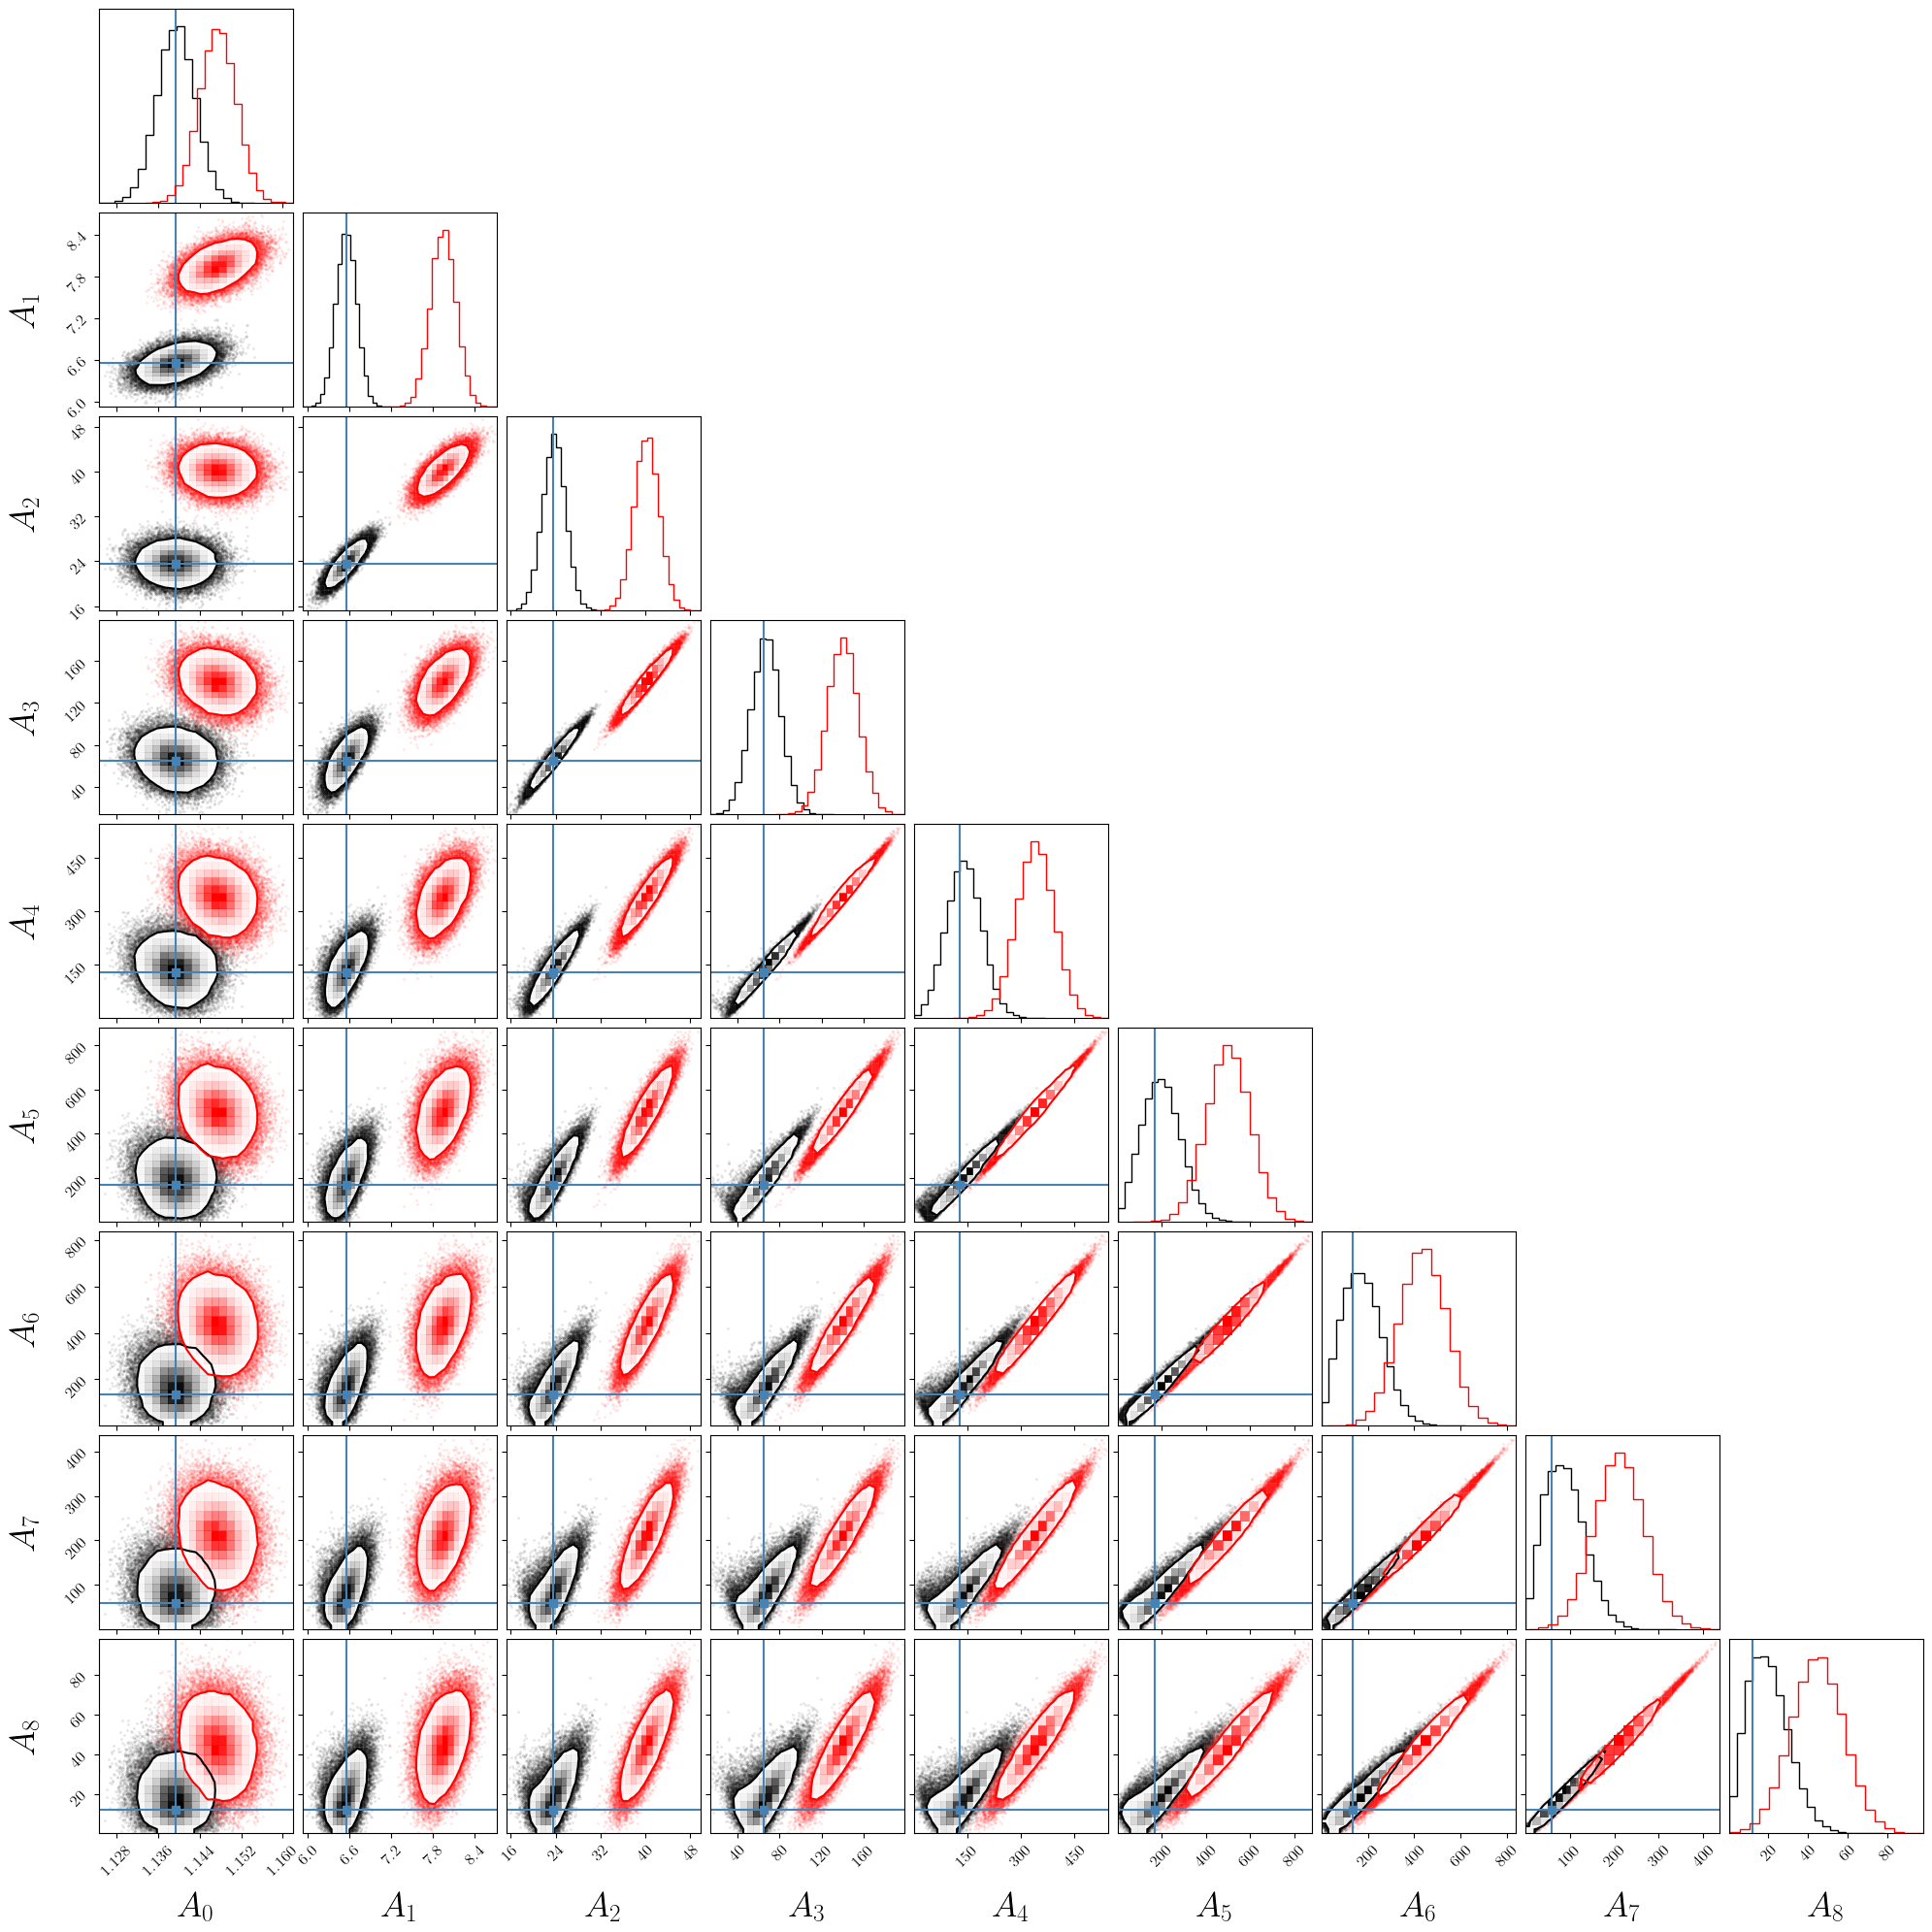

In [14]:
fig = corner.corner(
    A_samples,
    levels=[0.9],
    labels=amp_labels,
    truths=ls_a,
    label_kwargs={"fontsize": 26},
)
corner.corner(
    A_samples_p,
    color = 'red',
    levels=[0.9],
    fig=fig
);

In [15]:
unwrapped_phi_samples_p = phi_samples_p.copy()
for i in range(unwrapped_phi_samples_p.shape[1]):
    unwrapped_phi_samples_p[:,i] = analytic_fit.unwrap(unwrapped_phi_samples_p[:,i])

In [16]:
unwrapped_phi_samples_p[:,5] += 2*np.pi

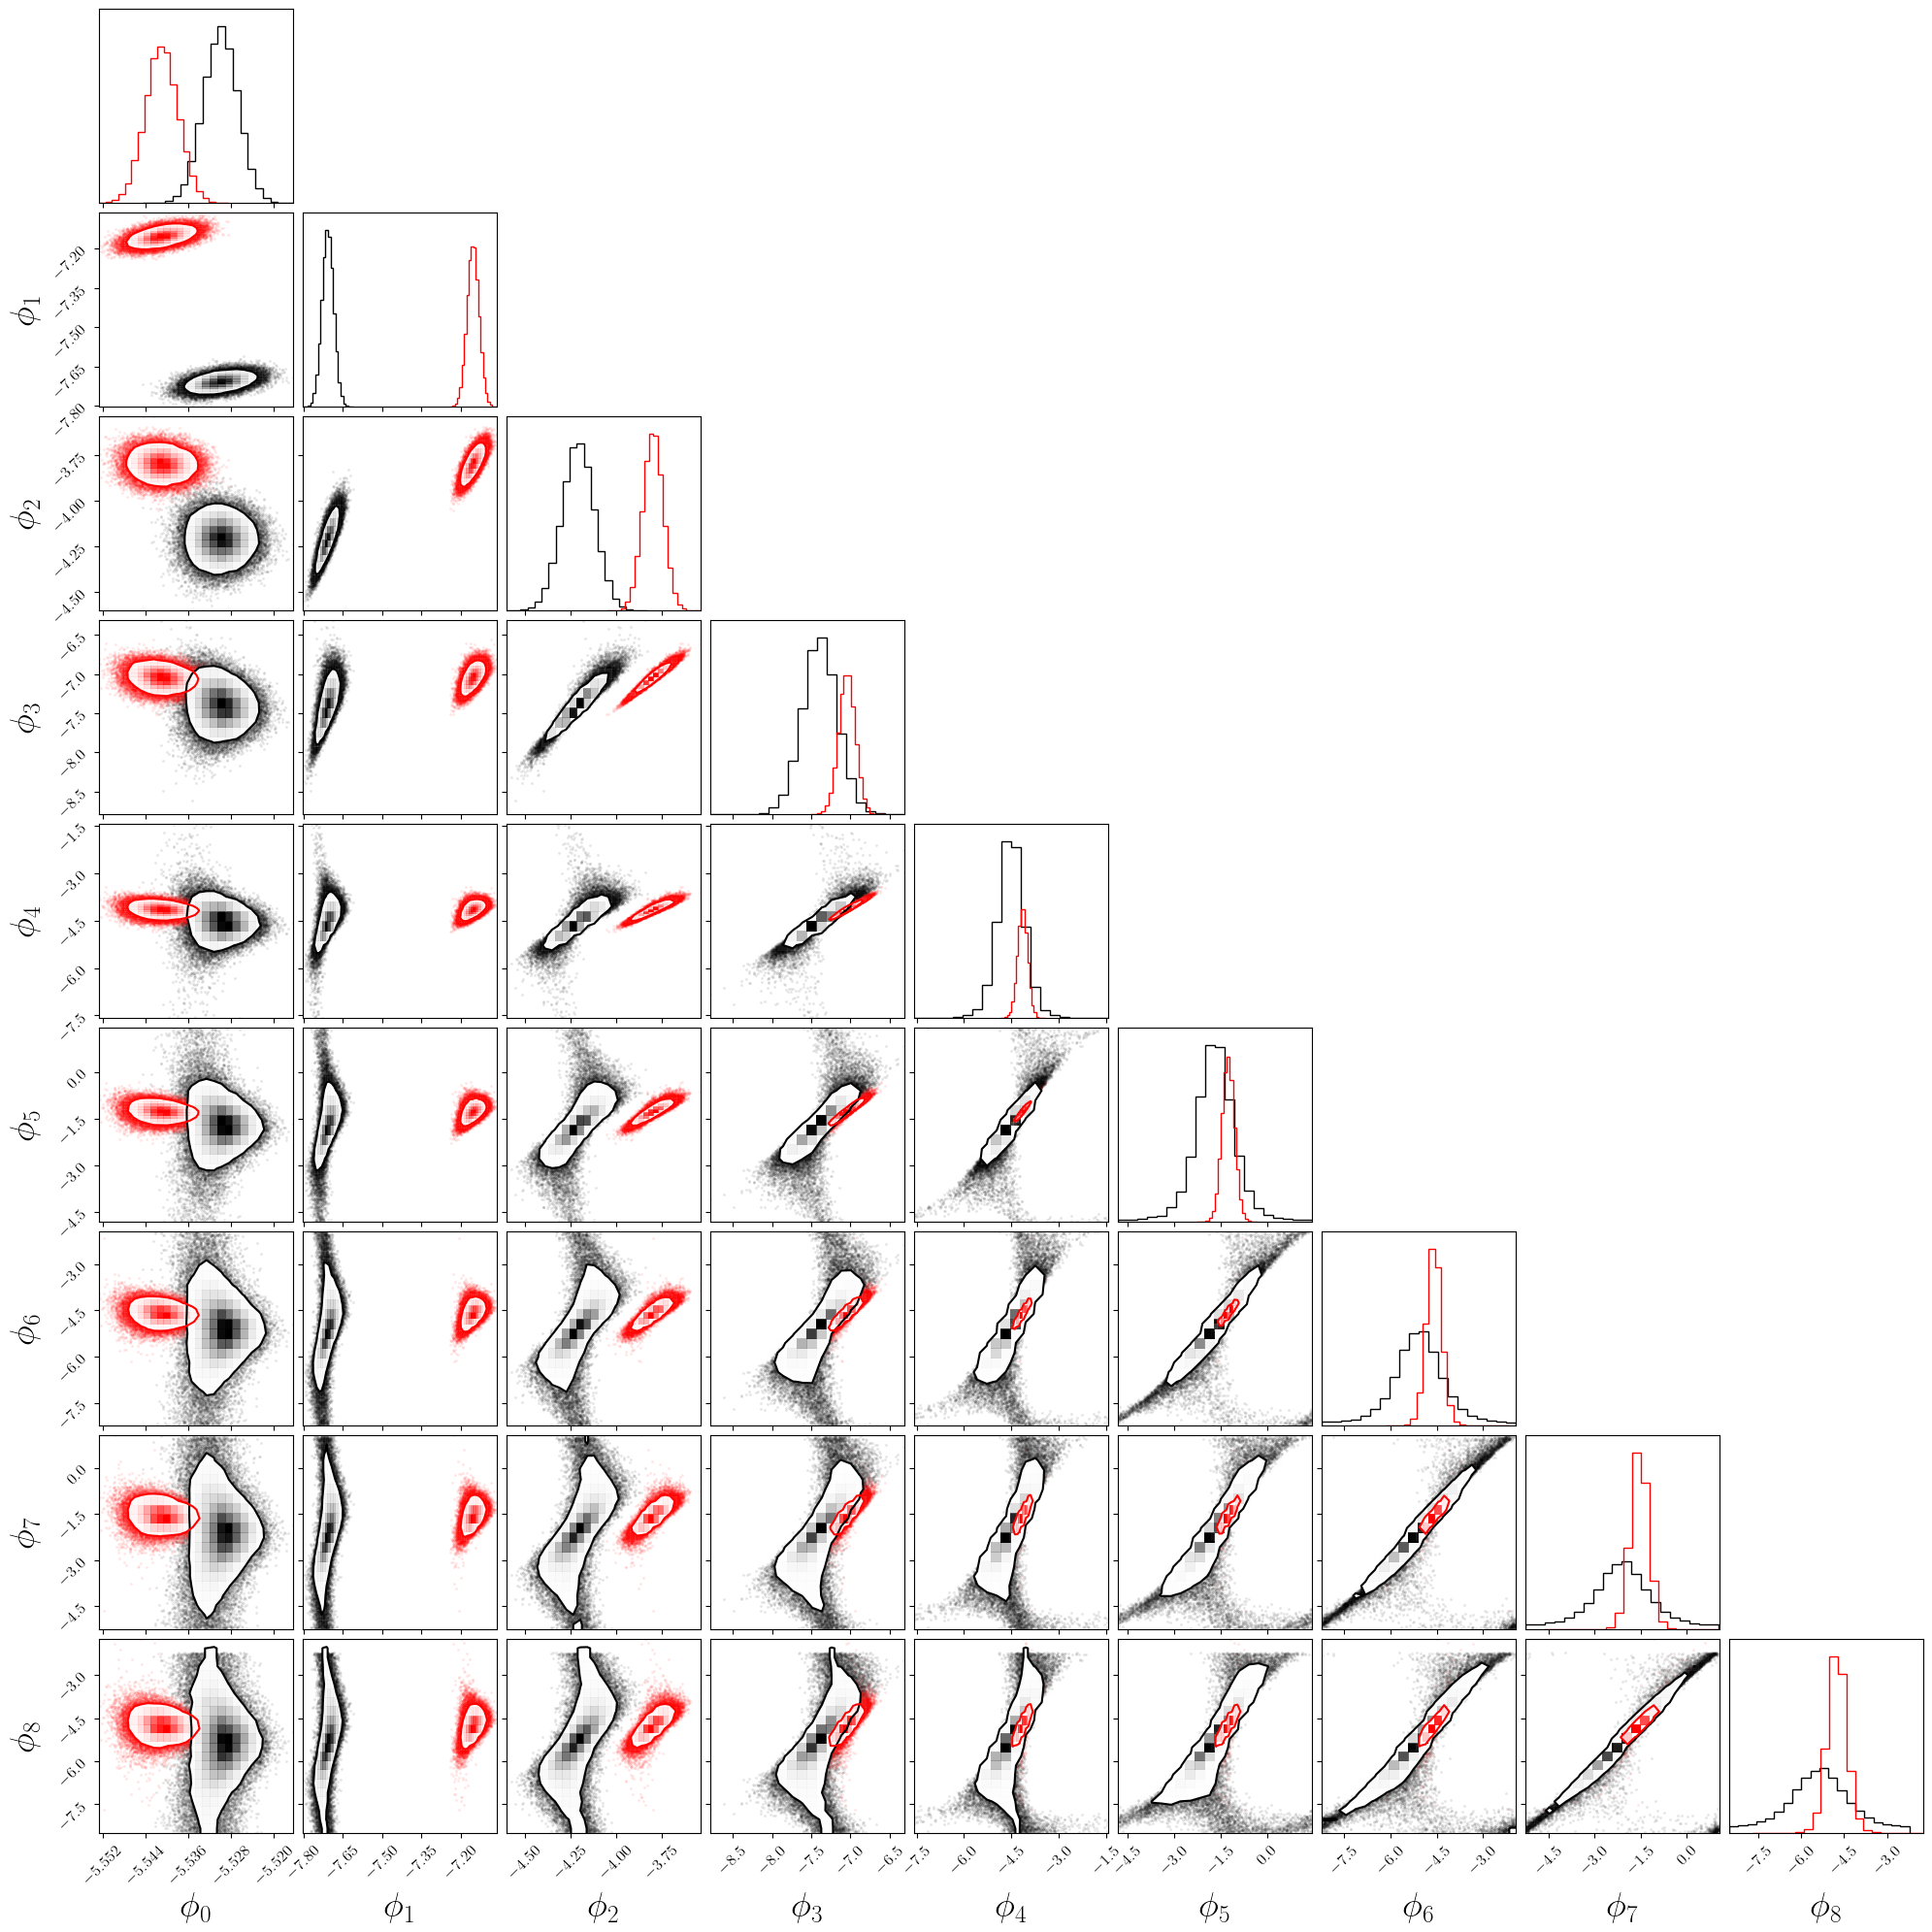

In [17]:
fig = corner.corner(
    unwrapped_phi_samples,
    levels=[0.9],
    labels=phase_labels,
    label_kwargs={"fontsize": 26},
)
corner.corner(
    unwrapped_phi_samples_p,
    color = 'red',
    levels=[0.9],
    fig=fig
);

However, now that we've perturbed the frequencies, a different mass and spin (and so a different set of frequencies) is what fit the data best. For a fair comparison we should probably be using the best-fit frequencies. Since I have to fix the frequencies in these fits, I obtain the best-fit frequencies via least-squares fits.

In [18]:
delta_array = np.zeros(len(modes))
delta_array[ntilde] = delta

epsilon, Mf_bf, chif_bf = qnmfits.calculate_epsilon(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest',
    T=T,
    delta=delta_array
)

In [19]:
epsilon

np.float64(0.004768955146924862)

In [20]:
Mf_bf, Mf, chif_bf, chif

(np.float64(0.9498306235780025),
 0.9516192579323307,
 np.float64(0.6820210932843527),
 np.float64(0.6864419212995437))

In [21]:
omega_bf = qnmfits.qnm.omega_list(modes, chif=chif_bf, Mf=Mf_bf)

In [22]:
omega_bf_perturbed = np.array(omega_bf.copy())
omega_bf_perturbed[ntilde] *= (1 + delta)

In [23]:
analytic_samples_p, A_samples_p, phi_samples_p = analytic_fit.sample(
    times=sim.times,
    data=data,
    sigma=sigma*np.ones_like(sim.times),
    qnm_omegas=omega_perturbed,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

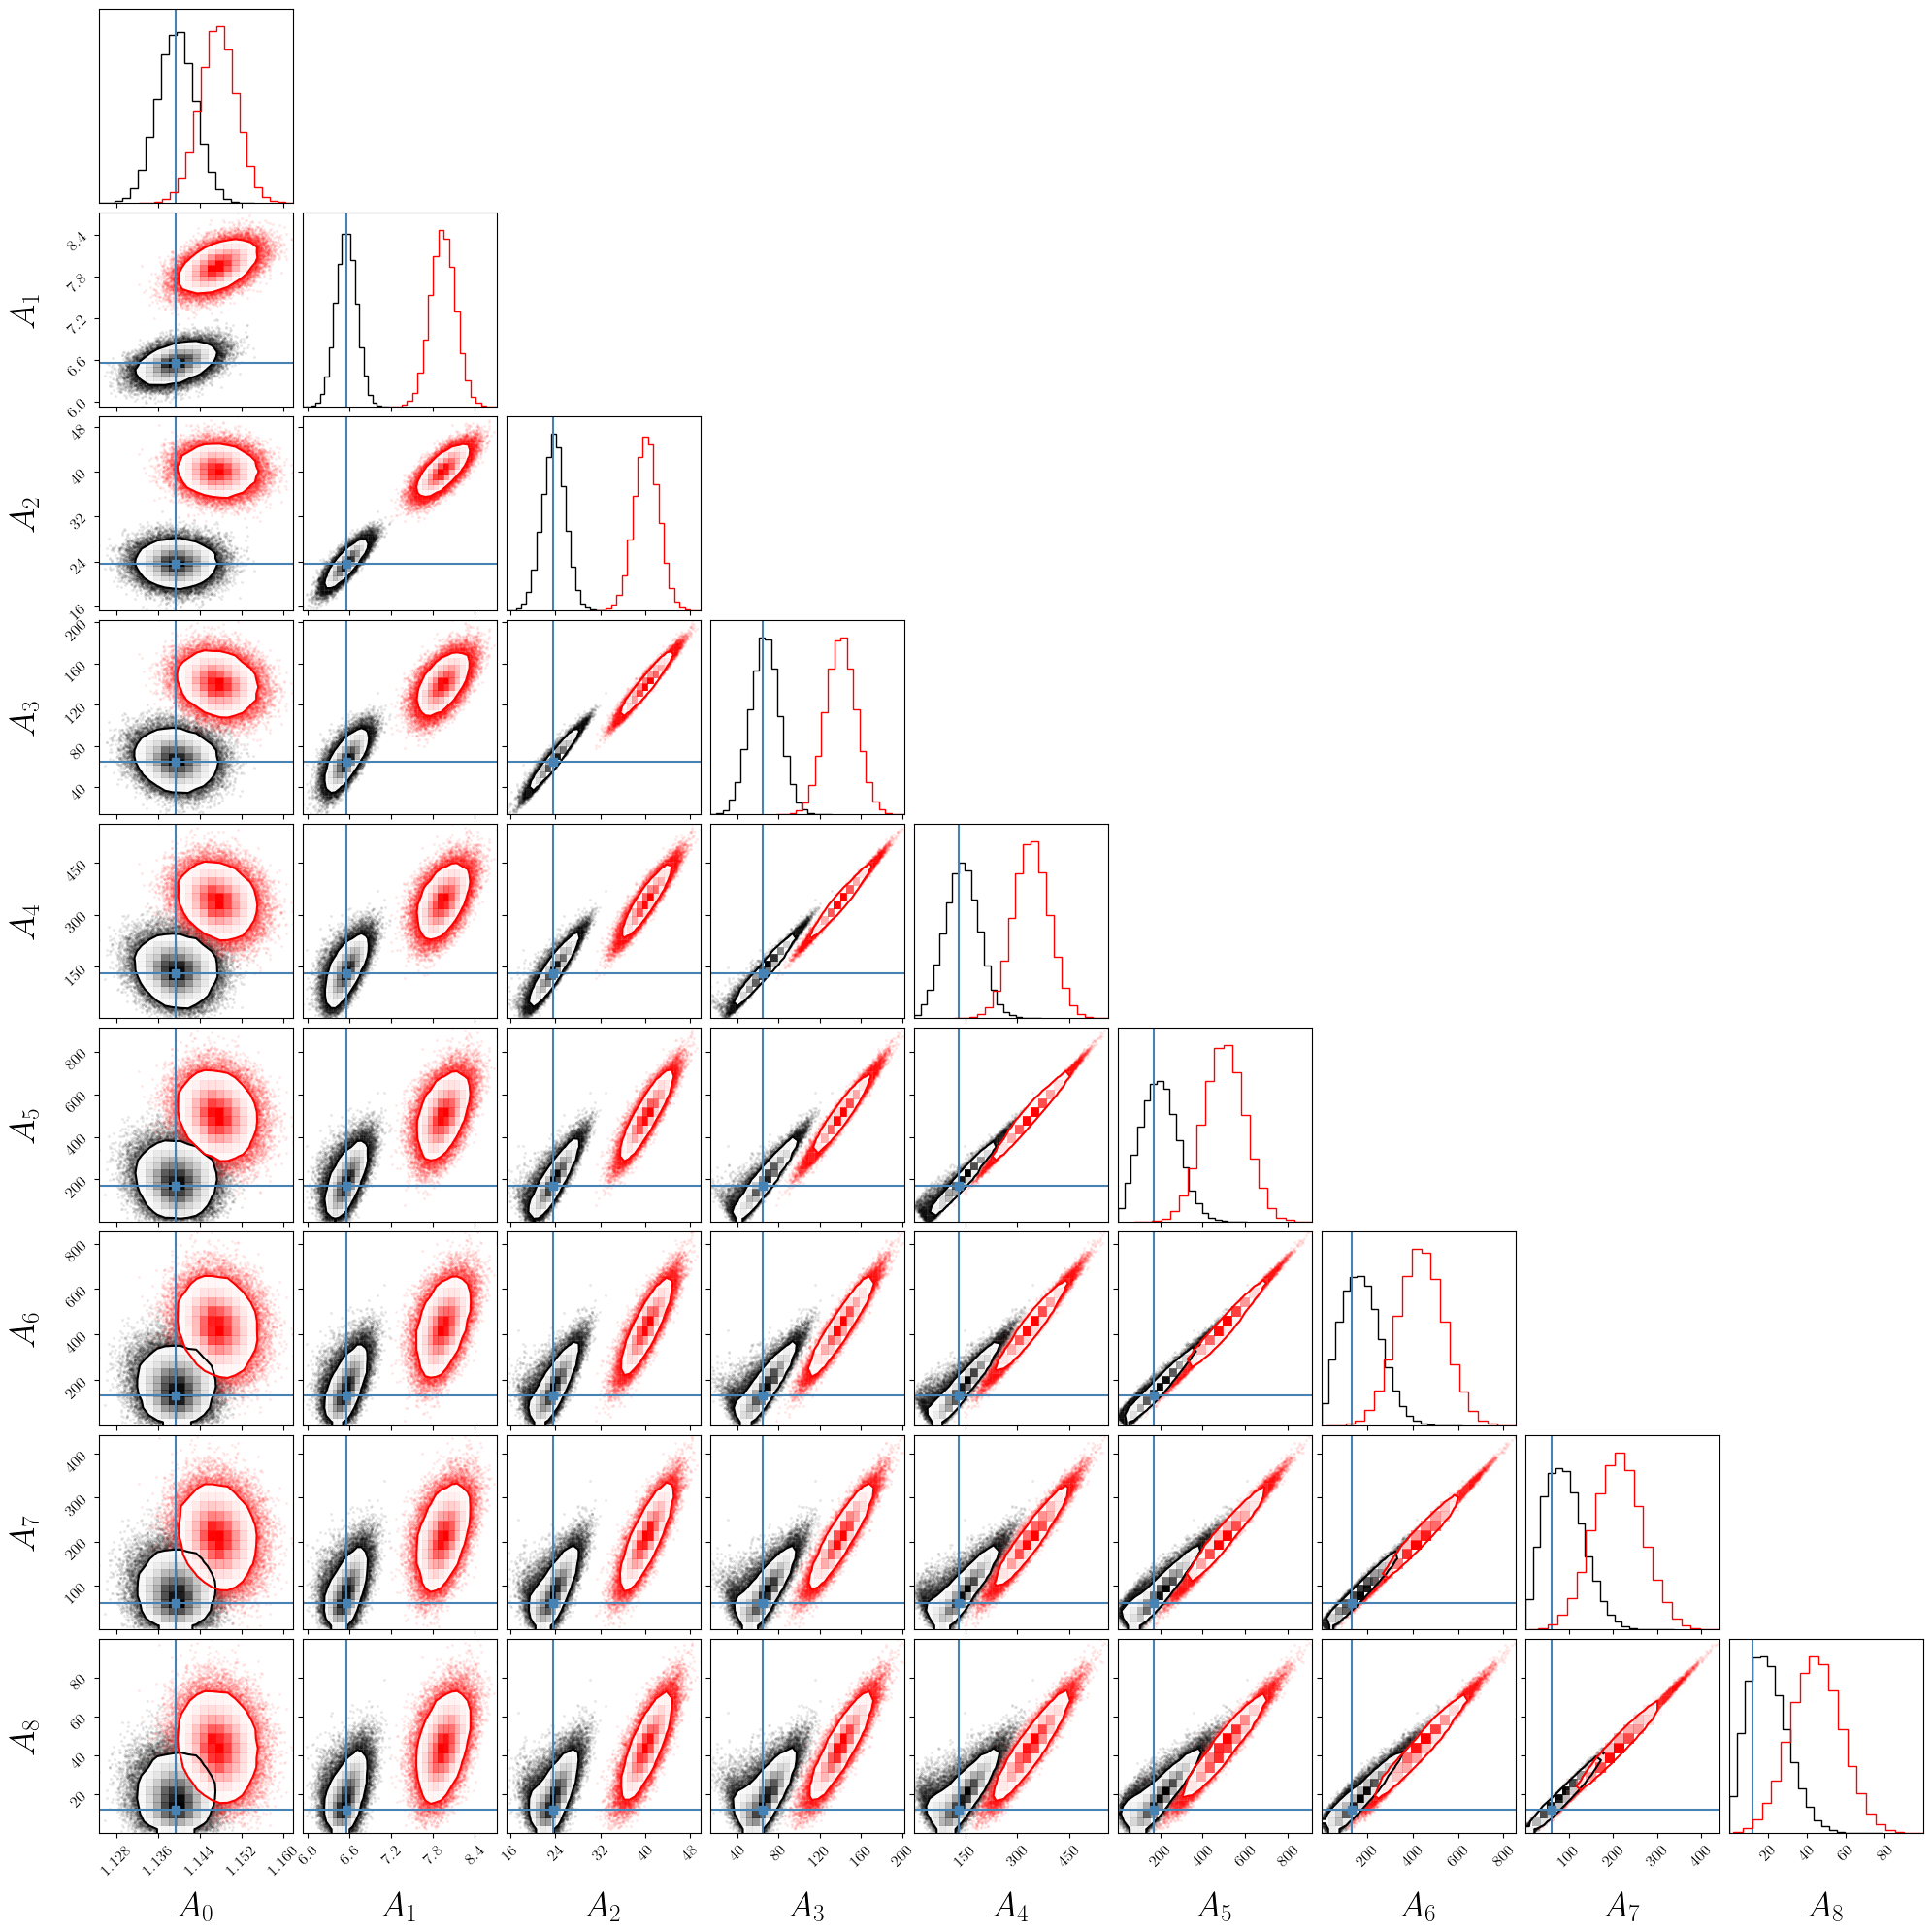

In [24]:
fig = corner.corner(
    A_samples,
    levels=[0.9],
    labels=amp_labels,
    truths=ls_a,
    label_kwargs={"fontsize": 26},
)
corner.corner(
    A_samples_p,
    color = 'red',
    levels=[0.9],
    fig=fig
);

In [25]:
unwrapped_phi_samples_p = phi_samples_p.copy()
for i in range(unwrapped_phi_samples_p.shape[1]):
    unwrapped_phi_samples_p[:,i] = analytic_fit.unwrap(unwrapped_phi_samples_p[:,i])

In [26]:
unwrapped_phi_samples_p[:,5] += 2*np.pi

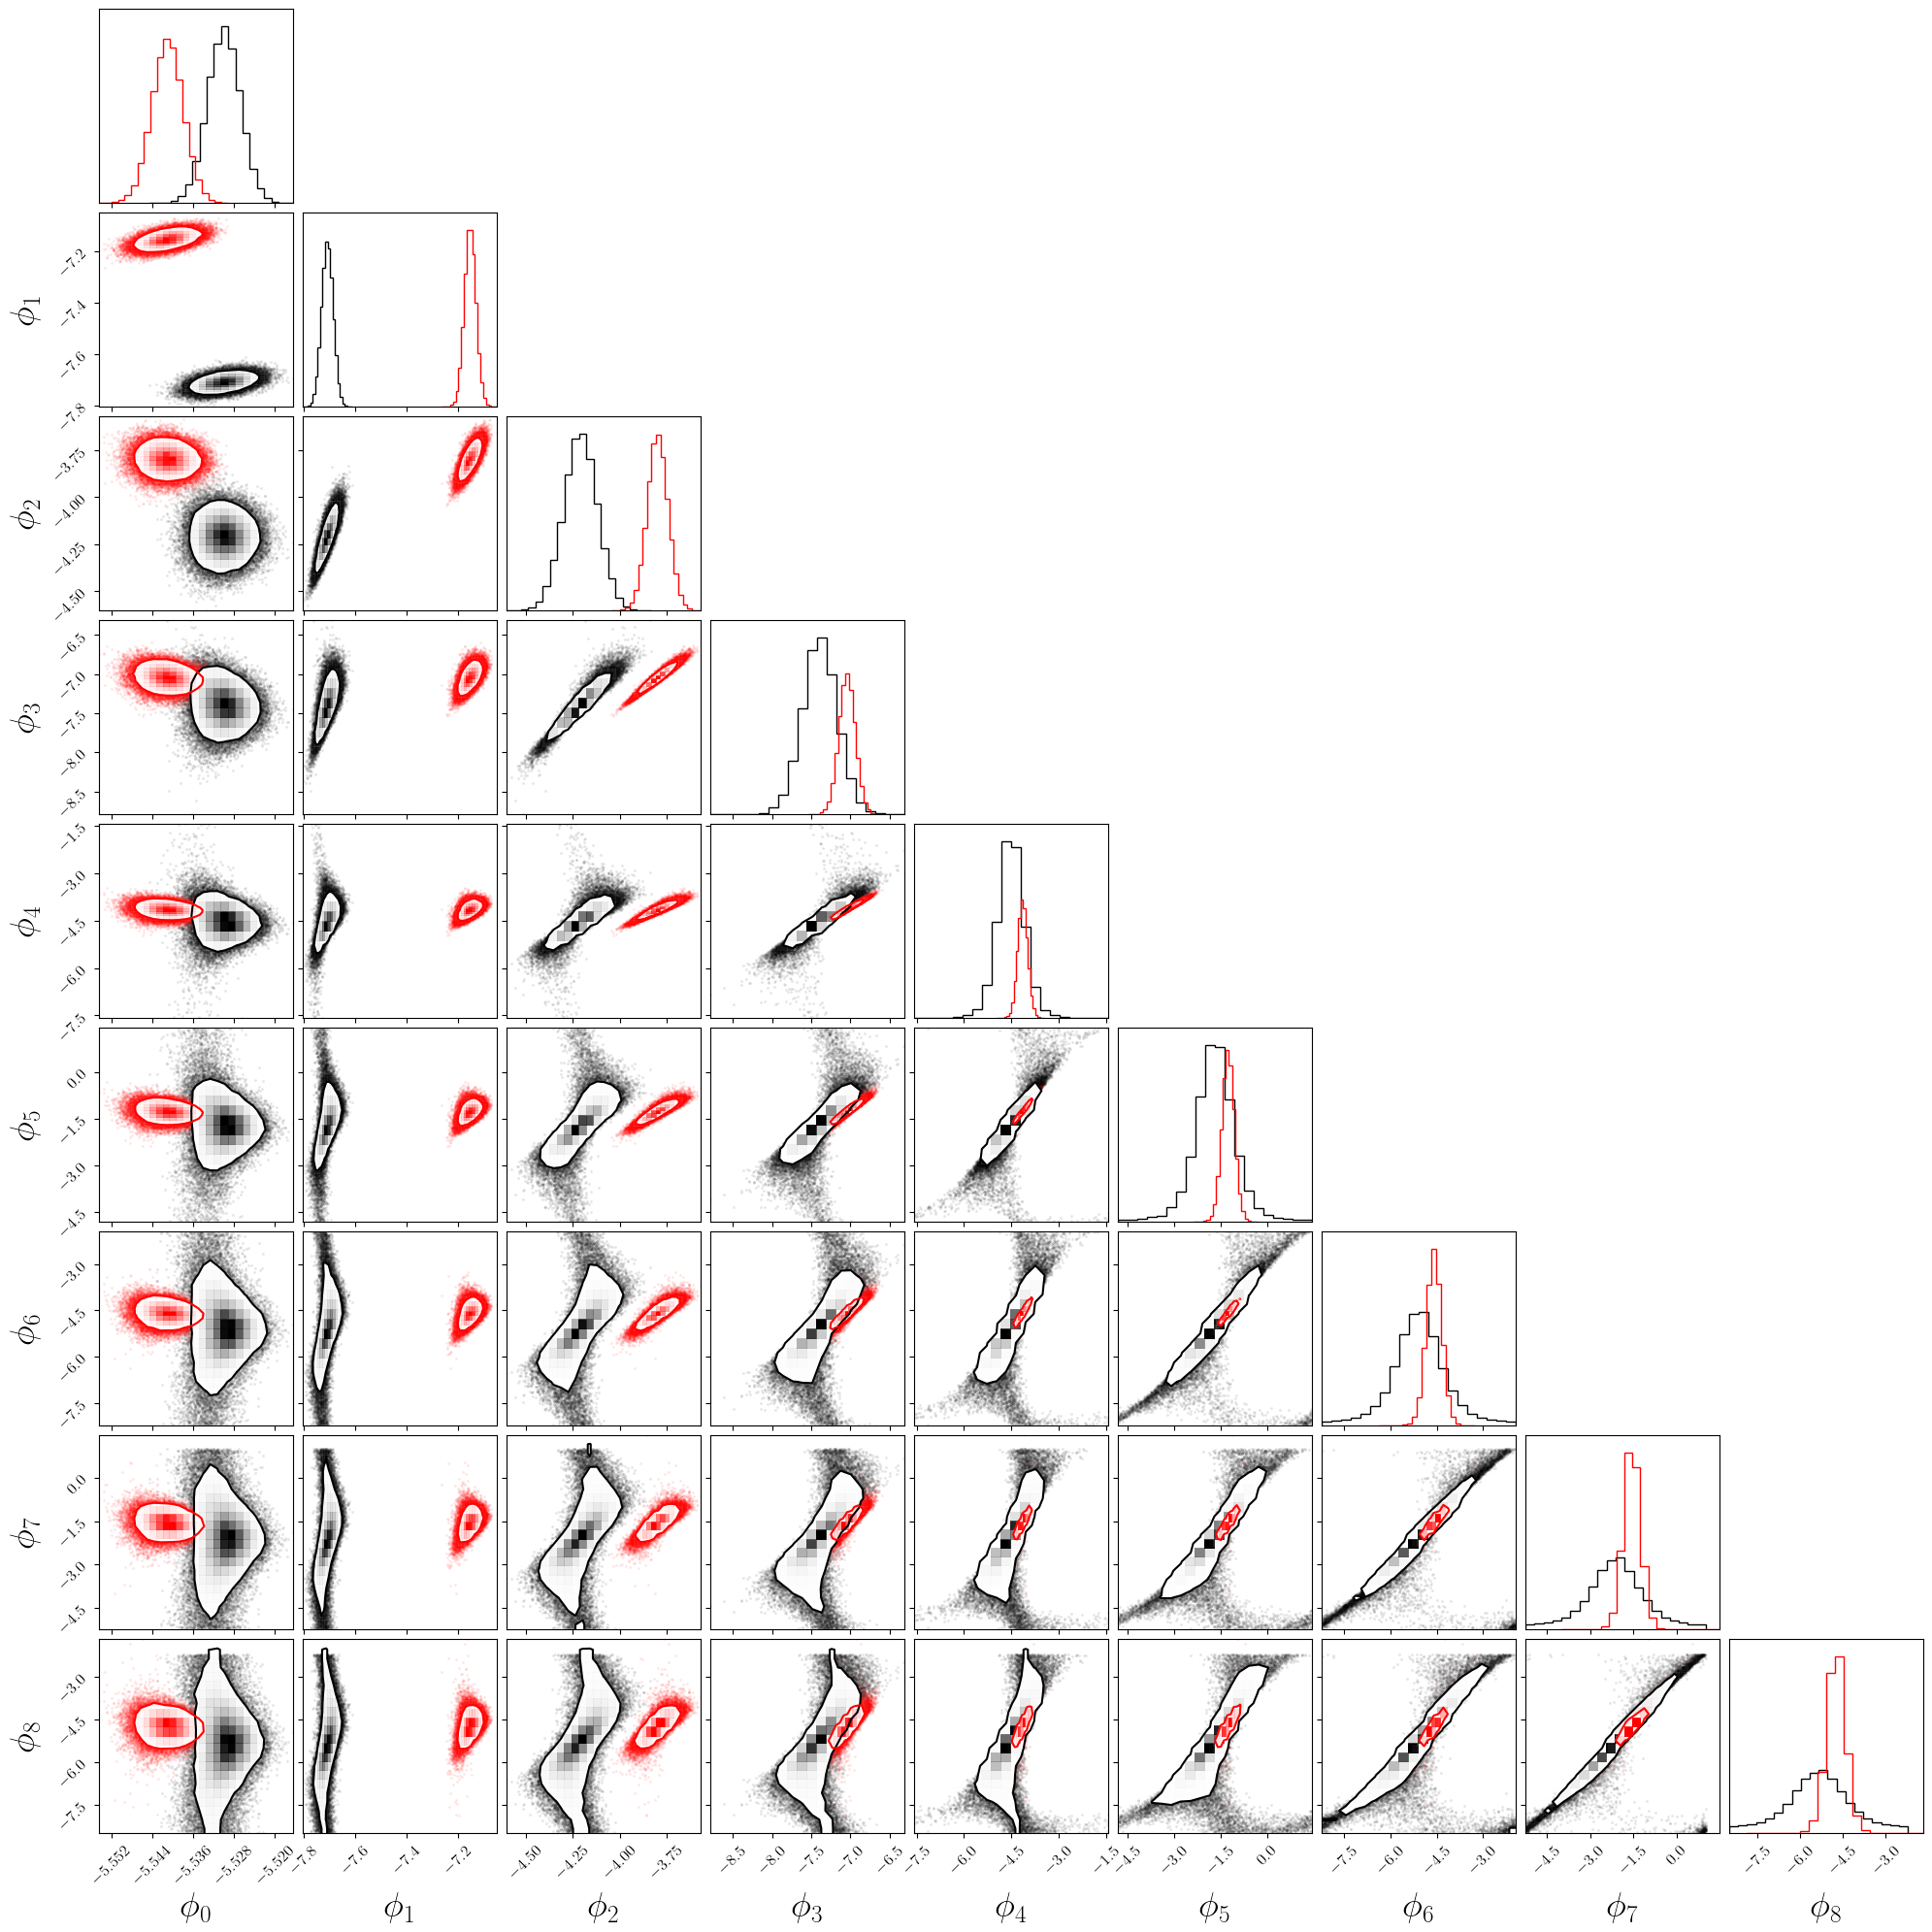

In [27]:
fig = corner.corner(
    unwrapped_phi_samples,
    levels=[0.9],
    labels=phase_labels,
    label_kwargs={"fontsize": 26},
)
corner.corner(
    unwrapped_phi_samples_p,
    color = 'red',
    levels=[0.9],
    fig=fig
);

There isn't much difference... just use the true mass and spin?

In [28]:
# Perturb each mode in turn with a fixed delta
delta = 0.05

fixed_delta_dict = {}
for ntilde in range(len(modes)):

    omega_perturbed = np.array(omega.copy())
    omega_perturbed[ntilde] *= (1 + delta)

    analytic_samples_p, A_samples_p, phi_samples_p = analytic_fit.sample(
        times=sim.times,
        data=data,
        sigma=sigma*np.ones_like(sim.times),
        qnm_omegas=omega_perturbed,
        t0=t0,
        t0_method='closest',
        T=T,
        reweight=False,
    )

    fixed_delta_dict[ntilde] = (analytic_samples_p, A_samples_p, phi_samples_p)

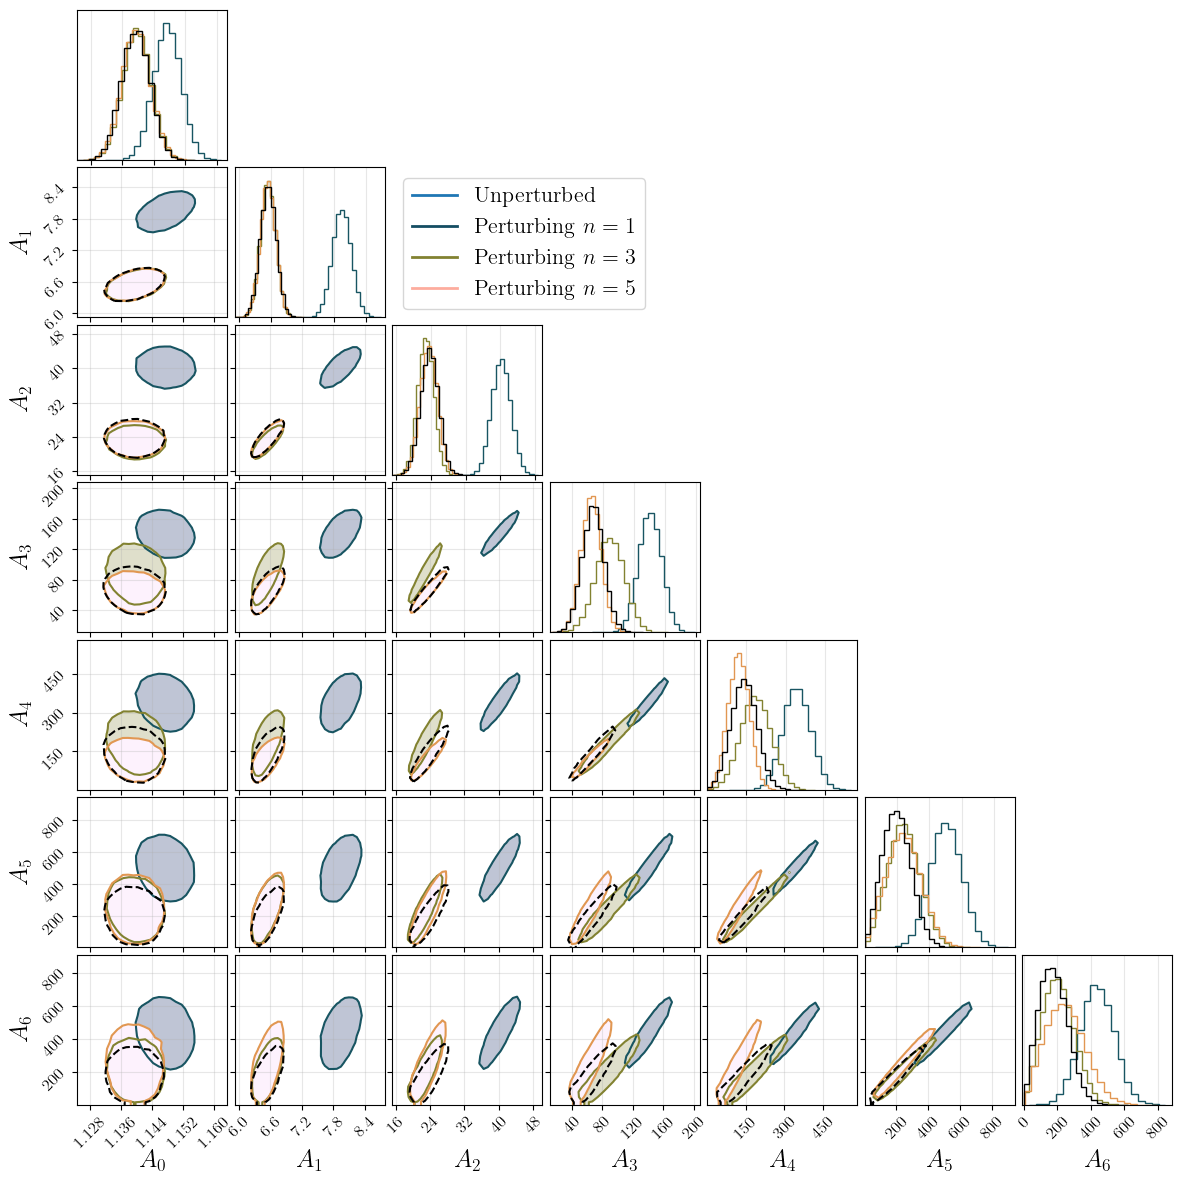

In [29]:
fig, axs = plt.subplots(7, 7, figsize=(12, 12))

c_list = [
    cm.batlow(0.2),
    cm.batlow(0.5),
    cm.batlow(0.7),
]

for i, ntilde in enumerate([1, 3, 5]):
    _, A_samples_p, _ = fixed_delta_dict[ntilde]
    min_sample = np.min(A_samples_p, axis=0)
    max_sample = np.max(A_samples_p, axis=0)
    range_sample = [(mi, ma) for mi, ma in zip(min_sample, max_sample)]
    corner.corner(
        A_samples_p[:,:-2],
        color = c_list[i],
        levels=[0.9],
        # range=range[:-2],
        plot_datapoints=False,
        plot_density=False,
        fill_contours=True,
        contourf_kwargs={'colors': [[0,0,0,0], list(cm.batlow(i/2))[:3] + [0.25]]},
        hist_kwargs={'density': True},
        fig=fig
    )

corner.corner(
    A_samples[:,:-2],
    levels=[0.9],
    labels=amp_labels[:-2],
    # truths=ls_a,
    label_kwargs={"fontsize": 18},
    plot_datapoints=False,
    no_fill_contours=True,
    fill_contours=False,
    plot_density=False,
    contour_kwargs={'linestyles': '--'},
    hist_kwargs={'density': True},
    fig=fig
)

legend_handles = [
    mpl.lines.Line2D([0], [0], color='C0', lw=2, label='Unperturbed'),
]
for ntilde in [1, 3, 5]:
    legend_handles.append(
        mpl.lines.Line2D([0], [0], color=cm.batlow(ntilde / 6), lw=2, label=rf'Perturbing $n={ntilde}$')
    )

# for i in range(6):
#     axs[6,i].tick_params(axis='x', which='major', labelsize=12)

for ax in axs.flatten():
    ax.grid(alpha=0.3)

N = 6
lim = axs[N, 0].get_ylim()
if lim[0] < 0:
    lim = (0, lim[1])
for j in range(0, N):
    axs[N,j].set_ylim(lim)

axs[1, 2].legend(handles=legend_handles, fontsize=16, loc='upper left');

In [30]:
rng = np.random.default_rng()

In [31]:
A_ticks = {
    0: [1.13, 1.14, 1.15, 1.16],
    1: [6.4, 7.2, 8.0, 8.8],
    2: [16, 24, 32, 40, 48],
    3: [50, 100, 150, 200],
    4: [150, 300, 450, 600],
    5: [250, 500, 750, 1000],
    6: [0, 250, 500, 750, 1000],
}

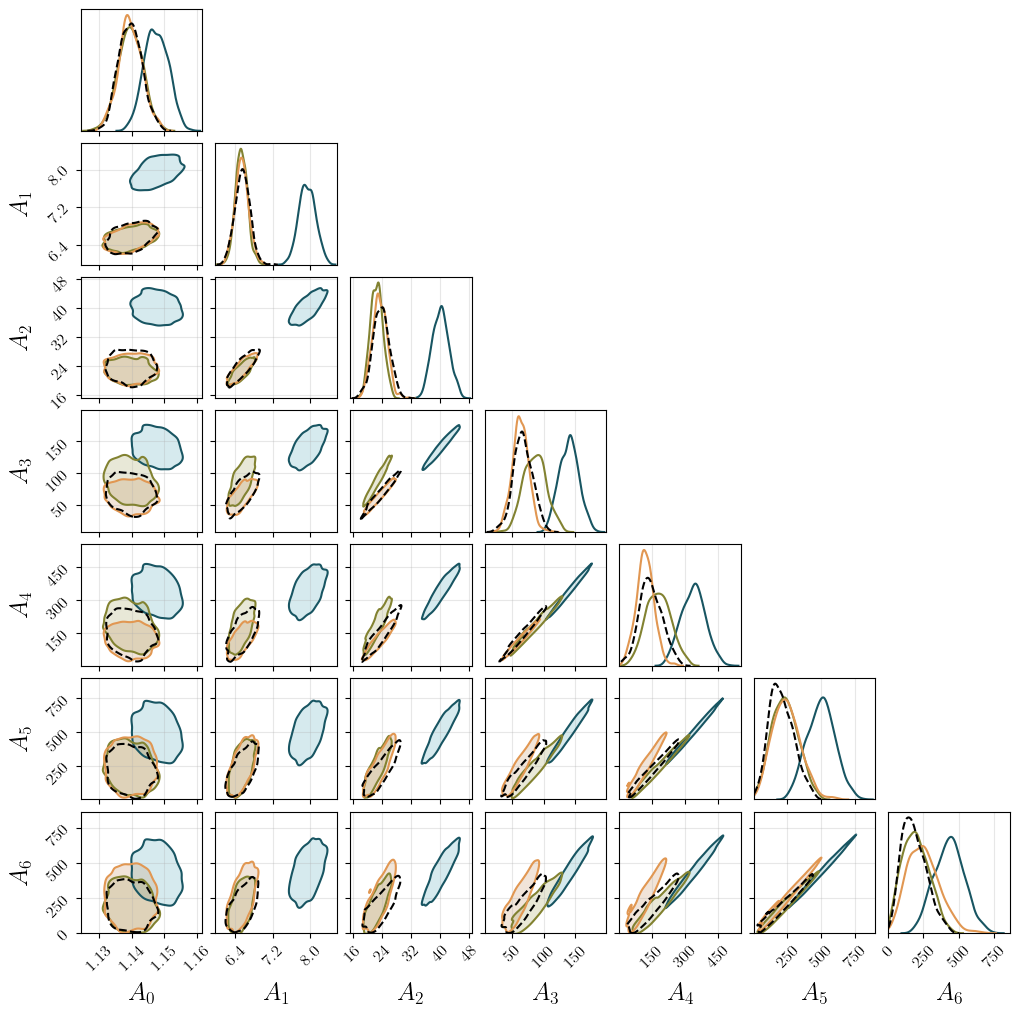

In [32]:
c_list = [
    cm.batlow(0.2),
    cm.batlow(0.5),
    cm.batlow(0.7),
]

Nplot = 6

fig, axs = plt.subplots(Nplot+1, Nplot+1, figsize=(12,12))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for ax in axs.flatten():
    ax.set_box_aspect(1)

for ax in axs.flatten():
    ax.grid(alpha=0.3)

for i in range(Nplot+1):
    for j in range(i+1, Nplot+1):
        axs[i,j].set_visible(False)

labelpad = 0.1

for i in range(1, Nplot+1):
    axs[i,0].set_ylabel(amp_labels[i], fontsize=18)
    axs[i,0].tick_params(axis='y', which='major', labelsize=12, rotation=45)
    axs[i,0].yaxis.set_label_coords(-0.3 - labelpad, 0.5)
    axs[i,0].set_yticks(A_ticks[i])

for j in range(Nplot+1):
    axs[Nplot,j].set_xlabel(amp_labels[j], fontsize=18)
    axs[Nplot,j].tick_params(axis='x', which='major', labelsize=12, rotation=45)
    axs[Nplot,j].xaxis.set_label_coords(0.5, -0.3 - labelpad)
    axs[Nplot,j].set_xticks(A_ticks[j])

for i in range(Nplot):
    for j in range(i+1):
        axs[i,j].set_xticks(A_ticks[j])
        axs[i,j].set_xticklabels([])

for i in range(Nplot+1):
    for j in range(1, i):
        axs[i,j].set_yticks(A_ticks[i])
        axs[i,j].set_yticklabels([])

for i, ntilde in enumerate([1, 3, 5]):

    color = c_list[i]
    _, A_samples_p, _ = fixed_delta_dict[ntilde]
    A_samples_p_sample = rng.choice(A_samples_p, size=500, replace=False)

    for j in range(Nplot+1):
        sns.kdeplot(
            x=A_samples_p_sample[:,j],
            ax=axs[j,j],
            color=color,
        )

    for j in range(1, Nplot+1):
        for k in range(j):
            sns.kdeplot(
                x=A_samples_p_sample[:,k],
                y=A_samples_p_sample[:,j],
                ax=axs[j,k],
                levels=[0.1,1],
                color=color,
                fill=True,
                alpha=0.2
            )
            sns.kdeplot(
                x=A_samples_p_sample[:,k],
                y=A_samples_p_sample[:,j],
                ax=axs[j,k],
                levels=[0.1,],
                color=color,
                zorder=10
            )

A_samples_sample = rng.choice(A_samples, size=500, replace=False)
color= 'k'
ls = '--'

for i in range(Nplot+1):
    sns.kdeplot(
        x=A_samples_sample[:,i],
        ax=axs[i,i],
        color=color,
        linestyle=ls,
    )

for i in range(1, Nplot+1):
    for j in range(i):
        sns.kdeplot(
            x=A_samples_sample[:,j],
            y=A_samples_sample[:,i],
            ax=axs[i,j],
            levels=[0.1,],
            color=color,
            linestyles=[ls],
            zorder=10
        )

for i in range(Nplot+1):
    axs[i,i].set_yticklabels([])
    axs[i,i].set_yticks([])
    axs[i,i].set_ylabel('')

for j in range(Nplot+1):
    lim = axs[Nplot, j].get_xlim()
    if lim[0] < 0:
        lim = (0, lim[1])
    for i in range(j, Nplot+1):
        axs[i,j].set_xlim(lim)

for i in range(1, Nplot+1):
    lim = axs[Nplot, i].get_xlim()
    for j in range(0, i):
        axs[i,j].set_ylim(lim)

Perturb just $n = 3$ with different $\delta$

In [33]:
# Perturb each mode in turn with a fixed delta
ntilde_star = 3
delta_list = [0.05, 0.1 , 0.15, 0.2]

fixed_n_dict = {}
for delta in delta_list:

    omega_perturbed = np.array(omega.copy())
    omega_perturbed[ntilde_star] *= (1 + delta)

    analytic_samples_p, A_samples_p, phi_samples_p = analytic_fit.sample(
        times=sim.times,
        data=data,
        sigma=sigma*np.ones_like(sim.times),
        qnm_omegas=omega_perturbed,
        t0=t0,
        t0_method='closest',
        T=T,
        reweight=False,
    )

    fixed_n_dict[delta] = (analytic_samples_p, A_samples_p, phi_samples_p)

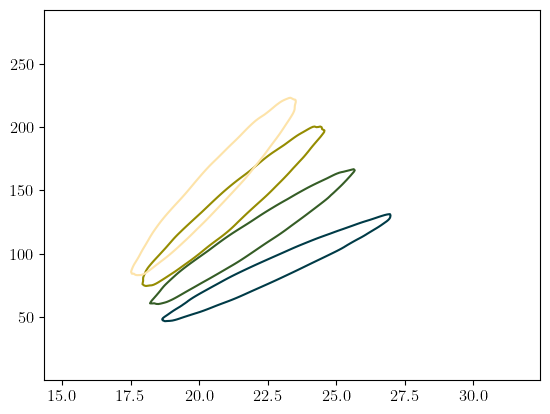

In [34]:
fig, ax = plt.subplots()

# c_list_fixed_n = ['k', cm.managua(.0), cm.managua(.33), cm.managua(.66), cm.managua(.99)]
c_list_fixed_n = [cm.bamako(.0), cm.bamako(.33), cm.bamako(.66), cm.bamako(.99)]

for i, delta in enumerate(delta_list):

    color = c_list_fixed_n[i]
    _, A_samples_p, _ = fixed_n_dict[delta]
    A_samples_p_sample = rng.choice(A_samples_p, size=25000, replace=False)

    sns.kdeplot(
        x=A_samples_p_sample[:,ntilde_star-1],
        y=A_samples_p_sample[:,ntilde_star],
        ax=ax,
        levels=[0.1,1],
        color=color,
    )

In [35]:
c_list = [
    cm.batlow(0.2),
    cm.batlow(0.5),
    cm.batlow(0.7),
]

c_list_fixed_n = [
    c_list[1],
    cm.corkO(.5), 
    cm.corkO(.25), 
    cm.corkO(.1)
]

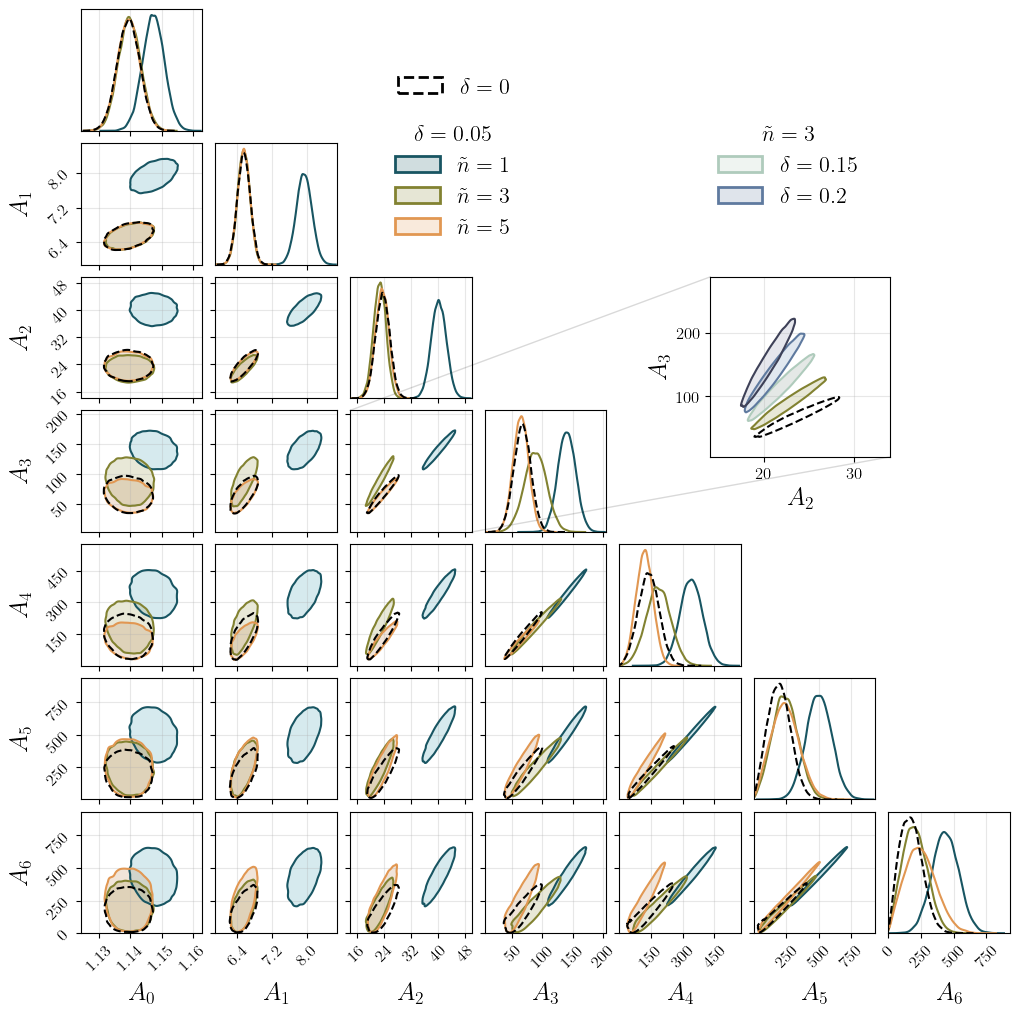

In [36]:
Nplot = 6

fig, axs = plt.subplots(Nplot+1, Nplot+1, figsize=(12,12))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for ax in axs.flatten():
    ax.set_box_aspect(1)

for ax in axs.flatten():
    ax.grid(alpha=0.3)

for i in range(Nplot+1):
    for j in range(i+1, Nplot+1):
        axs[i,j].set_visible(False)

labelpad = 0.1

for i in range(1, Nplot+1):
    axs[i,0].set_ylabel(amp_labels[i], fontsize=18)
    axs[i,0].tick_params(axis='y', which='major', labelsize=12, rotation=45)
    axs[i,0].yaxis.set_label_coords(-0.3 - labelpad, 0.5)
    axs[i,0].set_yticks(A_ticks[i])

for j in range(Nplot+1):
    axs[Nplot,j].set_xlabel(amp_labels[j], fontsize=18)
    axs[Nplot,j].tick_params(axis='x', which='major', labelsize=12, rotation=45)
    axs[Nplot,j].xaxis.set_label_coords(0.5, -0.3 - labelpad)
    axs[Nplot,j].set_xticks(A_ticks[j])

for i in range(Nplot):
    for j in range(i+1):
        axs[i,j].set_xticks(A_ticks[j])
        axs[i,j].set_xticklabels([])

for i in range(Nplot+1):
    for j in range(1, i):
        axs[i,j].set_yticks(A_ticks[i])
        axs[i,j].set_yticklabels([])

for i, ntilde in enumerate([1, 3, 5]):

    color = c_list[i]
    _, A_samples_p, _ = fixed_delta_dict[ntilde]
    A_samples_p_sample = rng.choice(A_samples_p, size=25000, replace=False)

    for j in range(Nplot+1):
        sns.kdeplot(
            x=A_samples_p_sample[:,j],
            ax=axs[j,j],
            color=color,
        )

    for j in range(1, Nplot+1):
        for k in range(j):
            sns.kdeplot(
                x=A_samples_p_sample[:,k],
                y=A_samples_p_sample[:,j],
                ax=axs[j,k],
                levels=[0.1,1],
                color=color,
                fill=True,
                alpha=0.2
            )
            sns.kdeplot(
                x=A_samples_p_sample[:,k],
                y=A_samples_p_sample[:,j],
                ax=axs[j,k],
                levels=[0.1,],
                color=color,
                zorder=10
            )

A_samples_sample = rng.choice(A_samples, size=25000, replace=False)
ref_color= 'k'
ref_ls = '--'

for i in range(Nplot+1):
    sns.kdeplot(
        x=A_samples_sample[:,i],
        ax=axs[i,i],
        color=ref_color,
        linestyle=ref_ls,
    )

for i in range(1, Nplot+1):
    for j in range(i):
        sns.kdeplot(
            x=A_samples_sample[:,j],
            y=A_samples_sample[:,i],
            ax=axs[i,j],
            levels=[0.1,],
            color=ref_color,
            linestyles=[ref_ls],
            zorder=10
        )

for i in range(Nplot+1):
    axs[i,i].set_yticklabels([])
    axs[i,i].set_yticks([])
    axs[i,i].set_ylabel('')

for j in range(Nplot+1):
    lim = axs[Nplot, j].get_xlim()
    if lim[0] < 0:
        lim = (0, lim[1])
    for i in range(j, Nplot+1):
        axs[i,j].set_xlim(lim)

for i in range(1, Nplot+1):
    lim = axs[Nplot, i].get_xlim()
    for j in range(0, i):
        axs[i,j].set_ylim(lim)

inset = fig.add_axes((0.65, 0.507, 0.15, 0.15))

inset.grid(alpha=0.3)
inset.set_box_aspect(1)

inset.set_xlabel(amp_labels[ntilde_star-1], fontsize=18)
inset.set_ylabel(amp_labels[ntilde_star], fontsize=18)

fig.add_artist(
    ConnectionPatch(
        xyA=(0,1), 
        coordsA=axs[ntilde_star, ntilde_star-1].transAxes, 
        xyB=(0,1), 
        coordsB=inset.transAxes,
        color='k',
        alpha=0.15,
        zorder=1.
        )
    )

fig.add_artist(
    ConnectionPatch(
        xyA=(1,0), 
        coordsA=axs[ntilde_star, ntilde_star-1].transAxes, 
        xyB=(1,0), 
        coordsB=inset.transAxes,
        color='k',
        alpha=0.15,
        zorder=1.
        )
    )

for i, delta in enumerate(delta_list):

    color = c_list_fixed_n[i]
    _, A_samples_p, _ = fixed_n_dict[delta]
    A_samples_p_sample = rng.choice(A_samples_p, size=25000, replace=False)

    sns.kdeplot(
        x=A_samples_p_sample[:,ntilde_star-1],
        y=A_samples_p_sample[:,ntilde_star],
        ax=inset,
        levels=[0.1,1],
        color=color,
        fill=True,
        alpha=0.2
    )

    sns.kdeplot(
        x=A_samples_p_sample[:,ntilde_star-1],
        y=A_samples_p_sample[:,ntilde_star],
        ax=inset,
        levels=[0.1,1],
        color=color,
        zorder=10
    )

sns.kdeplot(
    x=A_samples_sample[:,ntilde_star-1],
    y=A_samples_sample[:,ntilde_star],
    ax=inset,
    levels=[0.1,],
    color=ref_color,
    linestyles=[ref_ls],
    zorder=10
)

handles = [
    mpl.patches.Patch(
        color=ref_color, 
        linestyle=ref_ls, 
        linewidth=2,
        fill=None, 
        label='$\delta = 0$'
    ),
]
fig.legend(
    handles=handles, 
    fontsize=16, 
    loc='upper right', 
    frameon=False,
    bbox_to_anchor=(0.5, 0.84)
)
handles = [
    mpl.patches.Patch(
        linewidth=2,
        edgecolor=c_list[i], 
        facecolor=list(c_list[i])[:3] + [0.2],
        label=rf'$\tilde{{n}} = {ntilde}$'
    ) for i, ntilde in enumerate([1, 3, 5])
]
fig.legend(
    handles=handles, 
    fontsize=16, 
    loc='upper right', 
    frameon=False,
    bbox_to_anchor=(0.5, 0.8),
    title='$\delta = 0.05$',
    title_fontsize=16
)
handles = [
    mpl.patches.Patch(
        linewidth=2,
        edgecolor=c_list_fixed_n[i+1],
        facecolor=list(c_list_fixed_n[i+1])[:3] + [0.2], 
        label=rf'$\delta = {delta}$'
    ) for i, delta in enumerate(delta_list[2:])
]
fig.legend(
    handles=handles,
    fontsize=16, 
    loc='upper right', 
    frameon=False,
    bbox_to_anchor=(0.79, 0.8),
    title=r'$\tilde{{n}} = 3$',
    title_fontsize=16
)

fig.savefig('figures/bayesian_frequency_perturbations.pdf', dpi=300, bbox_inches='tight')

In [37]:
fixed_delta_dict_unwrapped = {}
for ntilde in [1, 3, 5]:
    _, _, phi_samples_p = fixed_delta_dict[ntilde]
    unwrapped_phi_samples_p = phi_samples_p.copy()
    for i in range(unwrapped_phi_samples_p.shape[1]):
        unwrapped_phi_samples_p[:,i] = analytic_fit.unwrap(unwrapped_phi_samples_p[:,i])
    fixed_delta_dict_unwrapped[ntilde] = unwrapped_phi_samples_p

In [38]:
fixed_delta_dict_unwrapped[1][:,5] += 2*np.pi

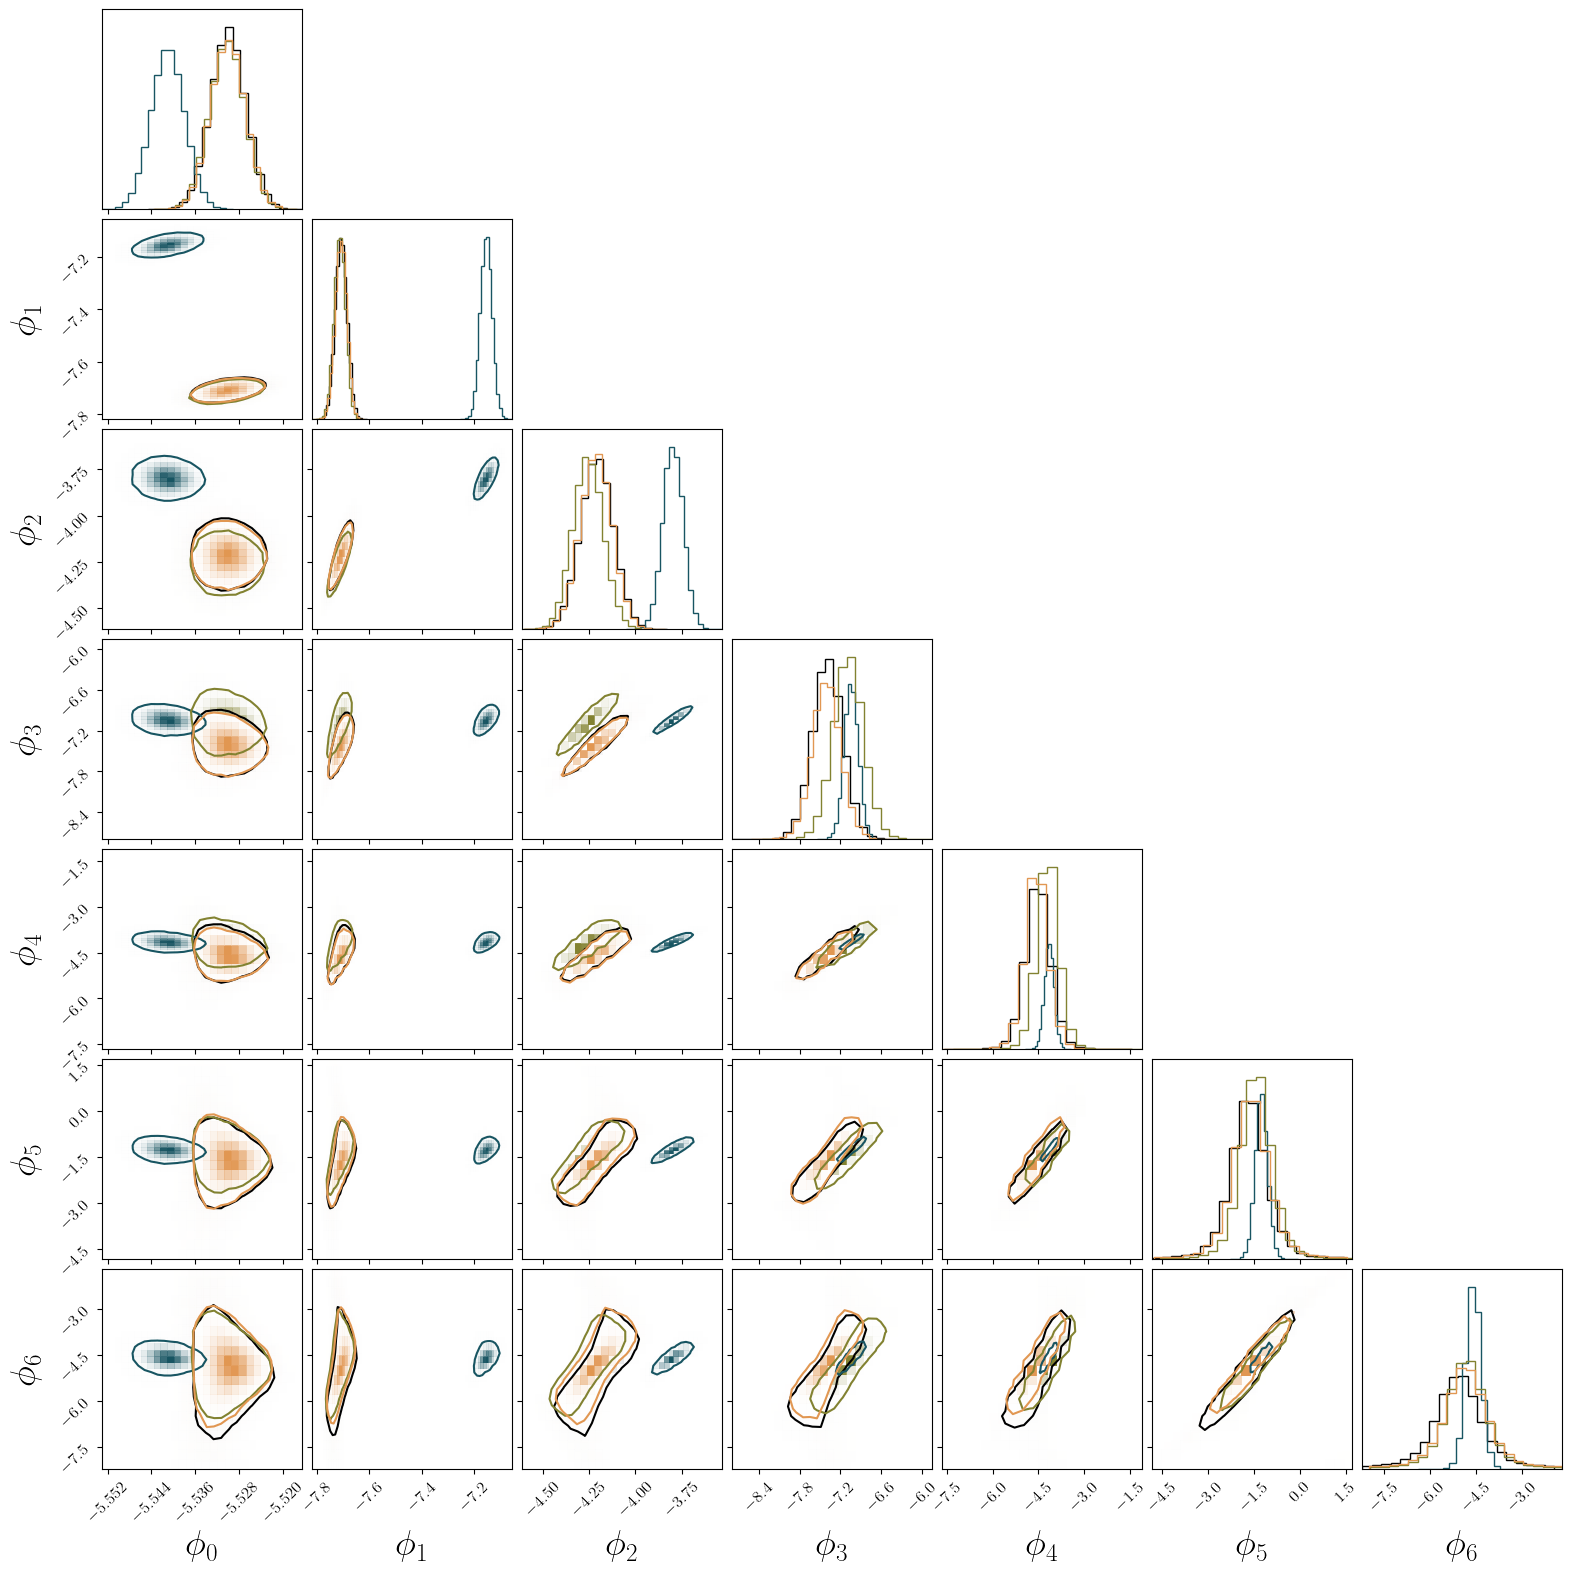

In [39]:
fig = corner.corner(
    unwrapped_phi_samples[:,:-2],
    levels=[0.9],
    labels=phase_labels[:-2],
    label_kwargs={"fontsize": 26},
    plot_datapoints=False,
)

for i, ntilde in enumerate([1, 3, 5]):
    color = c_list[i]
    phi_samples_p = fixed_delta_dict_unwrapped[ntilde]
    corner.corner(
        phi_samples_p[:,:-2],
        color=color,
        levels=[0.9],
        plot_datapoints=False,
        fig=fig
    )